# DMX Dev Notebook
Use this notebook to develop code to automatic DMX light fixtures to system sound

In [20]:
import sounddevice as sd
import numpy as np
import time
from tqdm import tqdm
import threading
from scipy import signal
import matplotlib.pyplot as plt
import librosa
%matplotlib inline

In [21]:
from PyDMXControl.controllers import OpenDMXController
from PyDMXControl.profiles.Generic import Dimmer, Custom

In [22]:

# Create an instance of the uDMX controller, 
#  this holds all the fixture information and outputs it.
# This will start outputting data immediately.
dmx = OpenDMXController()
# rgb_channels = ['dimmer', 'R', 'G', 'B', 'strobe', 'p1', 'p2']
# rgb_light1 = Custom(channels=7, start_channel=7)
# rgb_light2 = Custom(channels=7, start_channel=14)

In [23]:
# make the full party dict with all the lights (1 is rope lights, 2 is discoball, 3 is lasers, 4 is lamp, 5 and 6 is strobe, and then there are 8 7-channel RGB lights
party = {}
party['ropes'] = dmx.add_fixture(Dimmer)
party['discoball'] = dmx.add_fixture(Dimmer)
party['lasers'] = dmx.add_fixture(Dimmer)
party['lamp'] = dmx.add_fixture(Dimmer)
party['strobe_speed'] = dmx.add_fixture(Dimmer)
party['strobe_intensity'] = dmx.add_fixture(Dimmer)

for i in range(1, 9):
    party['rgb'+str(i)] = dmx.add_fixture(Custom(channels=7, start_channel=7*i))
null = dmx.add_fixture(Dimmer)

In [24]:
# make the strobe flash for 1 second
party['strobe_speed'].dim(255)
party['strobe_intensity'].dim(255)
time.sleep(1)
party['strobe_speed'].dim(0)
party['strobe_intensity'].dim(0)

In [6]:
while True:
    # make RGB green
    party['rgb1'].set_channels([255, 0, 255, 0, 0, 0, 0])

KeyboardInterrupt: 

In [7]:
# make the rgb white
party['ropes'].dim(0)

In [31]:
# find the black hole
audio_devices = sd.query_devices()
for device in audio_devices:
    if device['name'] == 'BlackHole 16ch':
        device_index = device['index']
print(f'Using: {audio_devices[device_index]["name"]}')

Using: BlackHole 16ch


/Users/f004swn/anaconda3/envs/spotify/lib/python3.11/site-packages/PyDMXControl/utils/timing/_Ticker.py:79: UserWarning: Ticker loop behind by 3.348470052083332ms, took 20.01513671875ms
  warn("Ticker loop behind by {:,}ms, took {:,}ms".format(-wait_dur, loop_dur))


In [9]:
audio_devices

  0 Background Music, Core Audio (2 in, 2 out)
  1 Background Music (UI Sounds), Core Audio (2 in, 2 out)
> 2 BlackHole 16ch, Core Audio (16 in, 16 out)
  3 MacBook Pro Microphone, Core Audio (1 in, 0 out)
  4 MacBook Pro Speakers, Core Audio (0 in, 2 out)
  5 ZoomAudioDevice, Core Audio (2 in, 2 out)
< 6 Multi-Output Device, Core Audio (0 in, 2 out)

In [20]:
# record from the back hole for 10 seconds
duration = 10
fs = 44100
recording = np.array([])
print('Recording')
with sd.InputStream(device=device_index, channels=1, samplerate=fs) as stream:
    for i in tqdm(range(int(duration))):
        recording = np.append(recording, stream.read(fs)[0])
print('Done')


Recording


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]

Done


In [21]:
sd.play(recording, fs)

In [6]:
lights = {}
for i in range(1,5):
    lights[str(i)] = dmx.add_fixture(Dimmer)
lights['strobe_speed'] = dmx.add_fixture(Dimmer)
lights['strobe_intensity'] = dmx.add_fixture(Dimmer)

In [7]:
# turn on 1
lights['1'].set_channels([0])

In [9]:
samplerate = 16000
# set the blocksize to 40Hz
blocksize = int(round(samplerate/40))

bass_range = [0, 8]
mid_range = [10, 30]
high_hat_range = [120, 200]

testvals = []
fft_spectrogram = []
max = 35
max_threshold = 20
min_threshold = 5
inter_brightness = 50
basspowers = []
highhats = []
power_spectra = []

high_thresh = 1

mids = []

total_powers = []

def light_sound(indata, outdata, frames, time, status=None):
    global power_spectrum
    power_spectrum = np.abs(np.fft.rfft(np.sum(indata, axis=0), n=blocksize))
    total_power = np.sum(power_spectrum)
    total_powers.append(total_power)
    power_spectra.append(power_spectrum.tolist())
    # get the average power in the bass range
    bass_power = np.mean(power_spectrum[bass_range[0]:bass_range[1]])
    print(bass_power)
    basspowers.append(bass_power)
    if bass_power > max:
        lights['1'].dim(255)
        #lights['strobe_intensity'].dim(255)
        #lights['strobe_speed'].dim(255)
    elif bass_power < min_threshold:
        lights['1'].dim(0)
    else:
        lights['1'].dim(int(inter_brightness*(bass_power-min_threshold)/(max_threshold-min_threshold)))

    # get the average power in the high hat range
    high_hat_power = np.mean(power_spectrum[high_hat_range[0]:high_hat_range[1]])
    highhats.append(high_hat_power)

    # if high_hat_power > high_thresh:
    #     lights['strobe_intensity'].dim(255)
    #     lights['strobe_speed'].dim(255)
    # elif high_hat_power < high_thresh:
    #     lights['strobe_intensity'].dim(0)
    #     lights['strobe_speed'].dim(0)

    # get the average power in the mid range
    # mid_power = np.mean(power_spectrum[mid_range[0]:mid_range[1]])
    # mids.append(mid_power)
    # if mid_power > max:
    #     lights['2'].dim(255)
    # elif mid_power < min_threshold:
    #     lights['2'].dim(MIN_)
    # else:
    #     lights['2'].dim(int(inter_brightness*(mid_power-min_threshold)/(max_threshold-min_threshold)))
    
    

with sd.InputStream(callback=light_sound, device=device_index, channels=1, samplerate=16000, blocksize=blocksize):
    # print the blocksize
    
    #sd.sleep(360000)
    while True:
        continue

1.5793228149414062
2.5732150077819824
2.9658994674682617
2.9324588775634766
1.1882734298706055
0.8692131042480469
1.7143712043762207
2.458073139190674
2.6385836601257324
1.9523496627807617
0.4688243865966797
0.7707633972167969
1.4572324752807617
1.8086509704589844
1.9951629638671875
1.3754568099975586
0.3264651298522949
0.6851596832275391
1.4385647773742676
1.887535810470581
1.5744647979736328
0.8792829513549805
0.0007863044738769531
0.6516690254211426
1.2555062770843506
1.4016369581222534
1.0980873107910156
0.7275886535644531
0.12574052810668945
0.6408061981201172
1.1428288221359253
1.2851811647415161
1.0606610774993896
0.4905071258544922
0.0022382736206054688
0.6718900203704834
0.8798226118087769
0.7734405994415283
0.7449840307235718
0.15893316268920898
0.5538064241409302
1.0503880977630615
2.1249375343322754
0.8161828517913818
0.03604006767272949
0.5559711456298828
0.7103159427642822
0.7792258262634277
0.885765790939331
0.550133466720581
0.3337319493293762
1.1636120080947876
0.65905

KeyboardInterrupt: 

In [ ]:
# make a spooky flicker effect
state = 'off'
while True:
    if state == 'off':
        val = 0
        state = 'on'
    else:
        val = 255
        state = 'off'
    time.sleep(1/36)
    #val = np.random.randint(100, 255)
    # alternate between off and on
    party['ropes'].dim(val)

In [9]:
# turn everything off
for key in party:
    party[key].dim(0)

ChannelNotFoundException: Channel dimmer not found for fixture #7

In [8]:
# make it go for 5 seconds
start = time.time()
while time.time() - start < 5:
    val = np.random.randint(50, 200)
    party['ropes'].dim(val)

In [10]:
SAMPLERATE = 16000
MINIMUM_FREQUENCY = 20
BLOCKSIZE = int(round(SAMPLERATE/MINIMUM_FREQUENCY))

In [57]:
party.keys()

dict_keys(['ropes', 'discoball', 'lasers', 'lamp', 'strobe_speed', 'strobe_intensity', 'rgb1', 'rgb2', 'rgb3', 'rgb4', 'rgb5', 'rgb6', 'rgb7', 'rgb8'])

/Users/f004swn/anaconda3/envs/spotify/lib/python3.11/site-packages/PyDMXControl/utils/timing/_Ticker.py:79: UserWarning: Ticker loop behind by 5.377034505208332ms, took 22.043701171875ms
  warn("Ticker loop behind by {:,}ms, took {:,}ms".format(-wait_dur, loop_dur))


In [48]:
SAMPLERATE = 16000
# set the blocksize to 20Hz
MINIMUM_FREQUENCY = 20
BLOCKSIZE = int(round(SAMPLERATE/MINIMUM_FREQUENCY))

# the frequency range for the bass
BASS_RANGE = [20, 200]
MID_RANGE = [350, 2000]
HIGH_RANGE = [1500, 20000]

BASS_MAX = 35
BASS_MAX_THRESHOLD = 10
BASS_MIN_THRESHOLD = 5
INTER_BRIGHTNESS = 50

MIN_BASS_BRIGHTNESS = 20

BASS_POWER_RANGE = BASS_MAX_THRESHOLD - BASS_MIN_THRESHOLD
BASS_BRIGHTNESS_RANGE = 255 - MIN_BASS_BRIGHTNESS

def get_bass_brightness(bass_power):
    return int(MIN_BASS_BRIGHTNESS + (bass_power - BASS_MIN_THRESHOLD) * (BASS_BRIGHTNESS_RANGE / BASS_POWER_RANGE))

HIGH_THRESH = 1

def light_sound(indata, outdata, frames, time, status=None):
    power_spectrum = np.abs(np.fft.rfft(np.sum(indata[:, :2], axis=1), n=BLOCKSIZE))
    total_power = np.sum(power_spectrum)
    bass_power = np.mean(power_spectrum[BASS_RANGE[0]:BASS_RANGE[1]])

    if bass_power > BASS_MAX:
        party['ropes'].dim(255)
        party['strobe_intensity'].dim(255)
        party['strobe_speed'].dim(255)
    elif bass_power < BASS_MIN_THRESHOLD:
        party['ropes'].dim(MIN_BASS_BRIGHTNESS)
    else:
        # map between min bass brightness and max bass brightness
        party['ropes'].dim(get_bass_brightness(bass_power))




    # get the average power in the mid range
    mid_power = np.mean(power_spectrum[MID_RANGE[0]:MID_RANGE[1]])

with sd.InputStream(callback=light_sound, device=device_index, channels=16, samplerate=SAMPLERATE, blocksize=BLOCKSIZE):
    # blocksize is 20Hz, which corresponds to 50ms, or 1/20th of a second
    # so the number of samples in each block is 1/20th of the sample rate, which is 800
    while True:
        continue

KeyboardInterrupt: 

In [11]:
# make a dict of RGB colors to their DMX values
# this is the color wheel
colors = {
    'red': [255, 0, 0],
    'orange': [255, 127, 0],
    'yellow': [255, 255, 0],
    'green': [0, 255, 0],
    'blue': [0, 0, 255],
    'purple': [75, 0, 130],
    'pink': [255, 0, 255],
    'white': [255, 255, 255]
}

def RGB(brightness=255, color='pink', strobe=False, strobe_speed=0):
    """
    Returns the list of 7 DMX values for the RGB light
    """
    if strobe:
        strobe_val = 255
    else:
        strobe_val = 0
    return [brightness, colors[color][0], colors[color][1], colors[color][2], strobe_speed, 0, 0]

In [12]:
def get_bass_brightness(bass_power):
    return int(MIN_BASS_BRIGHTNESS + (bass_power - BASS_MIN_THRESHOLD) * (BASS_BRIGHTNESS_RANGE / BASS_POWER_RANGE))

In [66]:
# make the template scene dict
SCENE_TEMPLATE = {
    'BASS_RANGE': [20, 200], # frequency range for bass
    'BASS_MAX': 35, # maximum bass power
    'BASS_MAX_THRESHOLD': 10, # bass power that will trigger the scene
    'BASS_MIN_THRESHOLD': 2, # bass power that will trigger the scene
    'MIN_BASS_BRIGHTNESS': 20, # minimum brightness that will be reached
    'MAX_BASS_BRIGHTNESS': 255, # maximum brightness that will be reached
    'BASS_MAP': party['ropes'], # light that bass controls
    'MID_RANGE': [350, 2000], # frequency range for mid
    'HIGH_RANGE': [2000, 16000], # frequency range for high hat
    'HIGH_THRESH': 2, # high hat power that will trigger the scene
    'HIGH_MAP': party['strobe_intensity'], # light that high hat controls (usually strobe)
    'STROBE_ENABLED': True, # whether the strobe will be enabled
    'STROBE_SPEED': 255, # speed of the strobe
    'DISCOBALL_ENABLED': True, # whether the discoball lights will be enabled
    'LASERS_ENABLED': True, # whether the lasers will be enabled
    'LAMP_ENABLED': True, # whether the lamp will be enabled
    'RGB_ENABLED': True, # whether the RGB lights will be enabled
    'RGB_MAX': 255, # maximum brightness of the RGB lights
    'RGB_MIN': 0, # minimum brightness of the RGB lights
    'RGB_THRESH': 1, # threshold for the RGB lights
    'RGB_MODE': 0, # mode of the RGB lights (0 is monochrome, 1 is reactive)
    'RGB_COLOR': 'pink', # color of the RGB lights (if monochrome)
    'RGB_STROBE_TRIGGER': 1, # threshold for the RGB lights to strobe
    'RGB_STROBE_SPEED': 255, # speed of the RGB lights when they strobe
    'RGB_STROBE_INTENSITY': 255, # intensity of the RGB lights when they strobe
    'RGB_STROBE_ENABLED': False, # whether the RGB lights will strobe
    'RGB_STROBE_MODE': 0 # mode of the RGB lights when they strobe (0 is monochrome, 1 is reactive)
}

In [56]:
# set rgb1 to red
party['rgb1'].set_channels(RGB(color='red'))

In [107]:
# warm (for nice acoustic songs)
warm = SCENE_TEMPLATE.copy()
warm['RGB_ENABLED'] = False
warm['STROBE_ENABLED'] = False
warm['BASS_RANGE'] = [20, 1000]
warm['MIN_BASS_BRIGHTNESS'] = 60
warm['BASS_MAX_THRESHOLD'] = 40
warm['LASERS_ENABLED'] = False
warm['DISCOBALL_ENABLED'] = False

# hip-hop
hiphop = SCENE_TEMPLATE.copy()
hiphop['BASS_RANGE'] = [20, 500]
hiphop['DISCOBALL_ENABLED'] = False
hiphop['LAMP_ENABLED'] = False
hiphop['BASS_MAX_THRESHOLD'] = 150
hiphop['MAX_BASS_BRIGHTNESS'] = 75
hiphop['MIN_BASS_BRIGHTNESS'] = 0
hiphop['HIGH_THRESH'] = 2.5

# dubstep
dubstep = SCENE_TEMPLATE.copy()
dubstep['BASS_RANGE'] = [20, 200]
dubstep['BASS_MAX'] = 100
dubstep['BASS_MAX_THRESHOLD'] = 50
dubstep['BASS_MIN_THRESHOLD'] = 5
dubstep['MIN_BASS_BRIGHTNESS'] = 20
dubstep['MAX_BASS_BRIGHTNESS'] = 100
dubstep['RGB_ENABLED'] = True
dubstep['RGB_MODE'] = 1
dubstep['RGB_THRESH'] = 1
dubstep['RGB_COLOR'] = 'blue'
dubstep['RGB_STROBE_ENABLED'] = True
dubstep['RGB_STROBE_MODE'] = 1
dubstep['RGB_STROBE_TRIGGER'] = 1
dubstep['RGB_STROBE_SPEED'] = 255
dubstep['RGB_STROBE_INTENSITY'] = 255
dubstep['STROBE_ENABLED'] = True
dubstep['STROBE_SPEED'] = 255
dubstep['DISCOBALL_ENABLED'] = False
dubstep['LAMP_ENABLED'] = False

# goosebumps
goosebumps = SCENE_TEMPLATE.copy()
goosebumps['RGB_MODE'] = 0
goosebumps['RGB_COLOR'] = 'green'
goosebumps['MIN_BASS_BRIGHTNESS'], goosebumps['MAX_BASS_BRIGHTNESS'] = 0, 0
goosebumps['LASERS_ENABLED'] = True
goosebumps['DISCOBALL_ENABLED'] = False
goosebumps['BASS_MAP'] = party['rgb1']



In [83]:
power_specs = []

In [84]:
def freq_to_index(freq):
    return int(round(freq * BLOCKSIZE / SAMPLERATE))

In [104]:
# just make a function that makes a function (nested func) and then give that output to the callback
# so it would be like with sd.InputStream(callback=light_sound(scene_dict), device=3, channels=16, samplerate=16000, blocksize=blocksize)

def scene(scene_dict_template):
    """
    Takes a scene dict, sets the lights to the init parameters, and returns a callback function to give to the 
    light controller thread.

    scene_dict is a dictionary that has the following keys:
    'BASS_RANGE': a list of two integers that are the start and end of the bass range
    'BASS_MAX': the maximum bass power that will be reached
    'BASS_MAX_THRESHOLD': the bass power that will trigger the scene
    'BASS_MIN_THRESHOLD': the bass power that will trigger the scene
    'MIN_BASS_BRIGHTNESS': the minimum brightness that will be reached
    'MAX_BASS_BRIGHTNESS': the maximum brightness that will be reached
    'BASS_MAP': the light that bass controls
    'HIGH_RANGE': a list of two integers that are the start and end of the high hat range
    'HIGH_THRESH': the high hat power that will trigger the scene
    'HIGH_MAP': the light that high hat controls (usually strobe)
    'STROBE_ENABLED': a boolean that determines whether the strobe will be enabled
    'STROBE_SPEED': the speed of the strobe
    'DISCOBALL_ENABLED': a boolean that determines whether the discoball lights will be enabled
    'LASERS_ENABLED': a boolean that determines whether the lasers will be enabled
    'LAMP_ENABLED': a boolean that determines whether the lamp will be enabled
    'RGB_ENABLED': a boolean that determines whether the RGB lights will be enabled
    'RGB_MAP': a list of integers that map the RGB lights to the frequency bins
    'RGB_MAX': the maximum brightness of the RGB lights
    'RGB_MIN': the minimum brightness of the RGB lights
    'RGB_THRESH': the threshold for the RGB lights
    'RGB_MODE': the mode of the RGB lights (0 is monochrome, 1 is reactive)
    'RGB_COLOR': the color of the RGB lights (if monochrome)
    'RGB_STROBE_TRIGGER': the threshold for the RGB lights to strobe
    'RGB_STROBE_SPEED': the speed of the RGB lights when they strobe
    'RGB_STROBE_INTENSITY': the intensity of the RGB lights when they strobe
    'RGB_STROBE_ENABLED': a boolean that determines whether the RGB lights will strobe
    'RGB_STROBE_MODE': the mode of the RGB lights when they strobe (0 is monochrome, 1 is reactive)
    """
    scene_dict = scene_dict_template.copy()
    # first update all the lights to match the scene
    party['ropes'].dim(scene_dict['MIN_BASS_BRIGHTNESS'])
    if scene_dict['DISCOBALL_ENABLED']:
        party['discoball'].dim(255)
    else:
        party['discoball'].dim(0)
    if scene_dict['LASERS_ENABLED']:
        party['lasers'].dim(255)
    else:
        party['lasers'].dim(0)
    if scene_dict['LAMP_ENABLED']:
        party['lamp'].dim(255)
    else:
        party['lamp'].dim(0)

    # get the rgb keys that exist in party
    rgb_lights = []
    for key in party.keys():
        if 'rgb' in key:
            rgb_lights.append(party[key])

    
    # init strobe to 0 always
    party['strobe_intensity'].dim(0)
    party['strobe_speed'].dim(0)

    if scene_dict['RGB_ENABLED']:
        if scene_dict['RGB_MODE'] == 0:
            for i in rgb_lights:
                i.set_channels(RGB(brightness=scene_dict['RGB_MAX'], color=scene_dict['RGB_COLOR']))
        elif scene_dict['RGB_MODE'] == 1:
            # do the reactive thing
            # (just set to dim pink for now)
            for i in rgb_lights:
                i.set_channels(RGB(brightness=scene_dict['RGB_MAX'], color='pink'))


    def get_dmx_value(bass_power, scene_dict):
        BASS_BRIGHTNESS_RANGE = scene_dict['MAX_BASS_BRIGHTNESS'] - scene_dict['MIN_BASS_BRIGHTNESS']
        BASS_POWER_RANGE = scene_dict['BASS_MAX_THRESHOLD'] - scene_dict['BASS_MIN_THRESHOLD']
        dmx_value = int(scene_dict['MIN_BASS_BRIGHTNESS'] + (bass_power - scene_dict['BASS_MIN_THRESHOLD']) * (BASS_BRIGHTNESS_RANGE / BASS_POWER_RANGE))
        return dmx_value

    def get_bass_brightness(bass_power):
        return int(scene_dict['MIN_BASS_BRIGHTNESS'] + (bass_power - scene_dict['BASS_MIN_THRESHOLD']) * (BASS_BRIGHTNESS_RANGE / BASS_POWER_RANGE))

    # turn all the frequency bins into indices
    scene_dict['BASS_RANGE'] = [freq_to_index(scene_dict['BASS_RANGE'][0]), freq_to_index(scene_dict['BASS_RANGE'][1])]
    scene_dict['HIGH_RANGE'] = [freq_to_index(scene_dict['HIGH_RANGE'][0]), freq_to_index(scene_dict['HIGH_RANGE'][1])]
    scene_dict['RGB_STROBE_TRIGGER'] = freq_to_index(scene_dict['RGB_STROBE_TRIGGER'])
    # check if anything is mapped to the strobe:
    strobe_maps = []
    for par, val in scene_dict.items():
        if party['strobe_intensity'] == val:
            strobe_maps.append(par)
    if not scene_dict['STROBE_ENABLED'] and (len(strobe_maps) > 0):
        print('Warning: strobe is not enabled but is mapped to a parameter. Strobe will not be enabled.')
        for par in strobe_maps:
            scene_dict[par] = null

    # turn lasers on or off
    if scene_dict['LASERS_ENABLED']:
        party['lasers'].dim(255)
    else:
        party['lasers'].dim(0)
    

    # now do the callback
    def out_scene(indata, outdata, frames, time, status=None):
        power_spectrum = np.abs(np.fft.rfft(np.sum(indata, axis=1), n=None))
        power_specs.append(power_spectrum.tolist())
        # get the average power in the bass range
        bass_power = np.mean(power_spectrum[scene_dict['BASS_RANGE'][0]:scene_dict['BASS_RANGE'][1]])
        # get the average power in the mid range
        mid_power = np.mean(power_spectrum[scene_dict['MID_RANGE'][0]:scene_dict['MID_RANGE'][1]])
        # get the average power in the high hat range
        high_hat_power = np.mean(power_spectrum[scene_dict['HIGH_RANGE'][0]:scene_dict['HIGH_RANGE'][1]])
        # get the total power
        total_power = np.sum(power_spectrum)

        # set the bass light
        if bass_power > scene_dict['BASS_MAX']:
            scene_dict['BASS_MAP'].dim(scene_dict['MAX_BASS_BRIGHTNESS'])
        elif bass_power < scene_dict['BASS_MIN_THRESHOLD']:
            scene_dict['BASS_MAP'].dim(scene_dict['MIN_BASS_BRIGHTNESS'])
        else:
            # map between min bass brightness and max bass brightness
            scene_dict['BASS_MAP'].dim(get_dmx_value(bass_power, scene_dict))
            print(get_bass_brightness(bass_power))

        # set the high hat light
        if high_hat_power > scene_dict['HIGH_THRESH']:
            scene_dict['HIGH_MAP'].dim(255)
        elif high_hat_power < scene_dict['HIGH_THRESH']:
            scene_dict['HIGH_MAP'].dim(0)

        # set the RGB lights
        if scene_dict['RGB_ENABLED']:
            if scene_dict['RGB_MODE'] == 1:
                # reactive
                if total_power > scene_dict['RGB_THRESH']:
                    for i in rgb_lights:
                        i.set_channels(RGB(brightness=scene_dict['RGB_MAX'], color='pink'))
                else:
                    for i in rgb_lights:
                        i.set_channels(RGB(brightness=scene_dict['RGB_MIN'], color='pink'))

        # set the strobe
        if scene_dict['STROBE_ENABLED']:
            if high_hat_power > scene_dict['HIGH_THRESH']:
                party['strobe_intensity'].dim(255)
                party['strobe_speed'].dim(255)
            elif high_hat_power < scene_dict['HIGH_THRESH']:
                party['strobe_intensity'].dim(0)
                party['strobe_speed'].dim(0)

    return out_scene

In [108]:
test_scene_callback = scene(goosebumps)
with sd.InputStream(callback=test_scene_callback, device=device_index, channels=16, samplerate=16000, blocksize=BLOCKSIZE):
    while True:
        continue

Exception ignored from cffi callback <function _StreamBase.__init__.<locals>.callback_ptr at 0x12aaa3d80>:
Traceback (most recent call last):
  File "/Users/f004swn/anaconda3/envs/spotify/lib/python3.11/site-packages/sounddevice.py", line 846, in callback_ptr
    return _wrap_callback(callback, data, frames, time, status)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/f004swn/anaconda3/envs/spotify/lib/python3.11/site-packages/sounddevice.py", line 2687, in _wrap_callback
    callback(*args)
  File "/var/folders/l2/ydrm4wvj4fv10hb243tjbs0c0000gn/T/ipykernel_1620/1611086479.py", line 121, in out_scene
  File "/Users/f004swn/anaconda3/envs/spotify/lib/python3.11/site-packages/PyDMXControl/profiles/defaults/_Fixture.py", line 53, in dim
    self.set_channel(channel, int(target_value))
  File "/Users/f004swn/anaconda3/envs/spotify/lib/python3.11/site-packages/PyDMXControl/profiles/defaults/_Fixture.py", line 294, in set_channel
    self.__channels[self.get_c

KeyboardInterrupt: 

In [46]:
party['ropes'].dim(255)


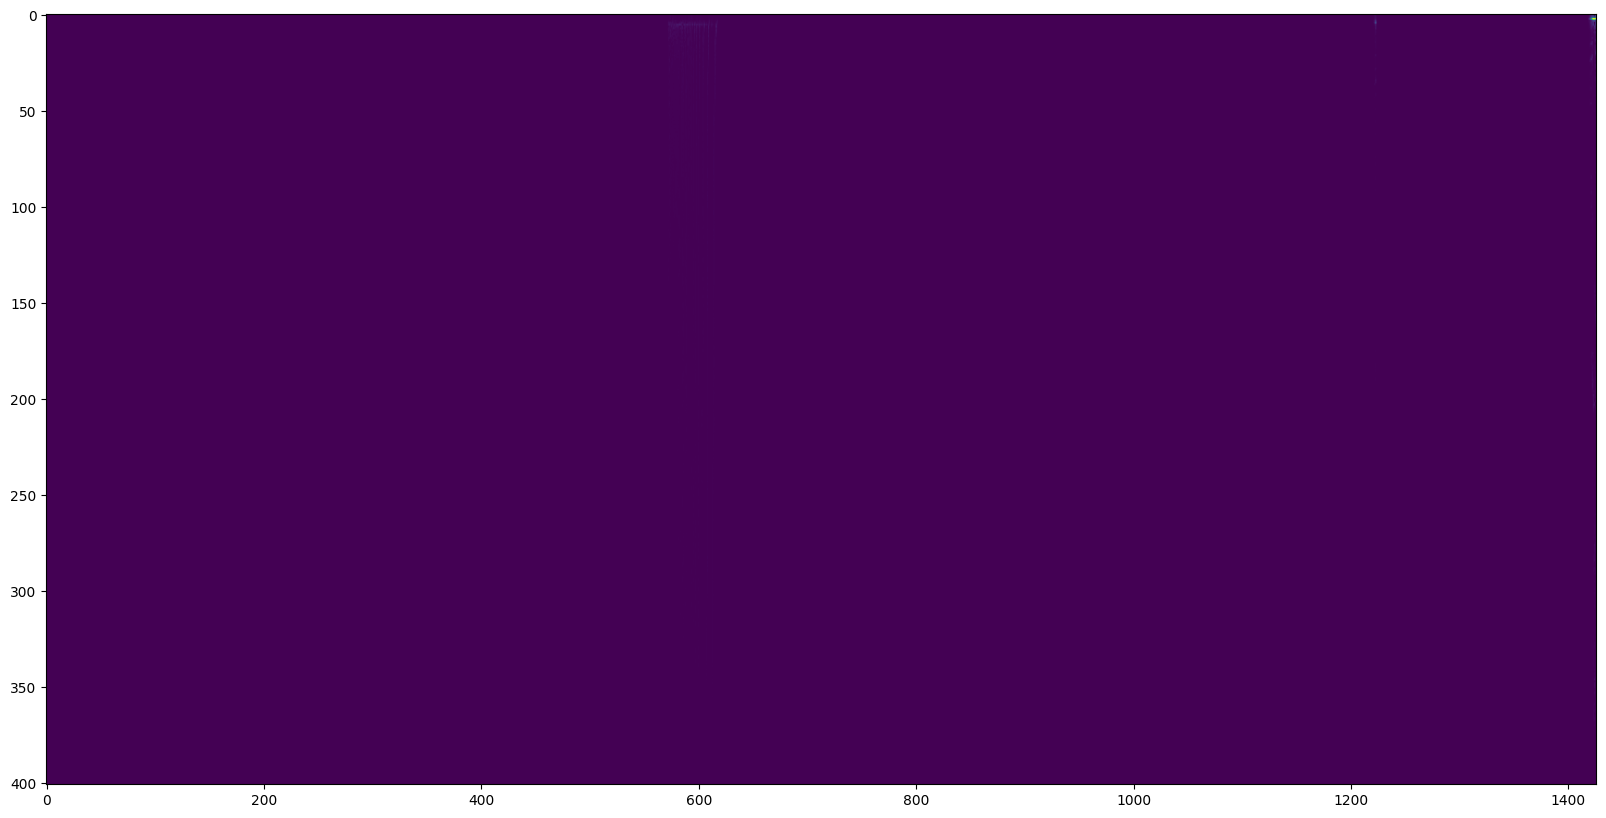

In [30]:
# plot all the power specs
plt.figure(figsize=(20, 10))
plt.imshow(np.array(power_specs).T, aspect='auto')
plt.show()


In [81]:
len(power_specs)

130

In [ ]:
# turn 1-4 on
lights['1'].dim(255)
lights['2'].dim(255)
lights['3'].dim(255)
lights['4'].dim(255)

In [ ]:
# light up the RGB to white
lights['rgb'].set_channels([255, 255, 255, 255, 0, 0, 0])

/Users/f004swn/anaconda3/envs/spotify/lib/python3.12/site-packages/PyDMXControl/utils/timing/_Ticker.py:79: UserWarning: Ticker loop behind by 4.225179036458332ms, took 20.891845703125ms
  warn("Ticker loop behind by {:,}ms, took {:,}ms".format(-wait_dur, loop_dur))
/Users/f004swn/anaconda3/envs/spotify/lib/python3.12/site-packages/PyDMXControl/utils/timing/_Ticker.py:79: UserWarning: Ticker loop behind by 121.47639973958333ms, took 138.14306640625ms
  warn("Ticker loop behind by {:,}ms, took {:,}ms".format(-wait_dur, loop_dur))


In [40]:
# load in an audiofile and resample it down to 16000Hz
local_sr = 16000
song = librosa.load('downloads/21 Savage - Bank Account.mp3', sr=local_sr)[0]

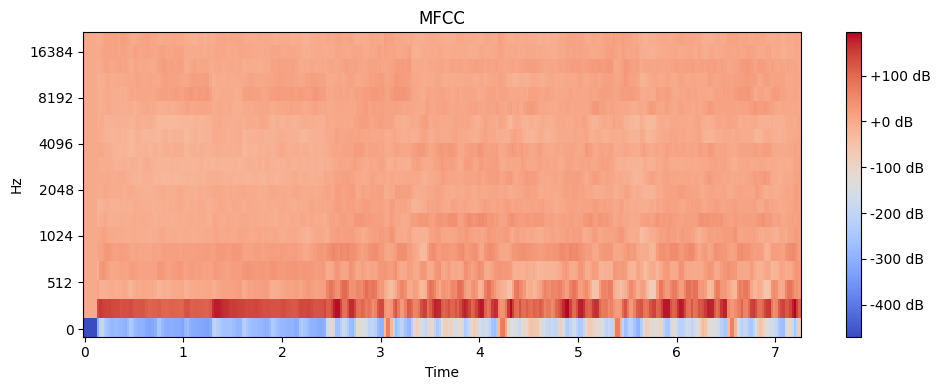

In [41]:
# use librosa to get MFCCs
mfccs = librosa.feature.mfcc(y=song[:local_sr*10], sr=local_sr)

# plot the MFCCs
plt.figure(figsize=(10, 4)) 
librosa.display.specshow(mfccs, x_axis='time', y_axis='mel', fmin=20, fmax=20000)
# plot the labeled colorbar
plt.colorbar(format='%+2.0f dB')
plt.title('MFCC')
plt.tight_layout()
plt.show()


In [42]:
start, end = 0, 10
sd.play(song[local_sr*start:local_sr*end], local_sr)


In [43]:
SAMPLERATE = 16000
# set the blocksize to 20Hz
MINIMUM_FREQUENCY = 20
BLOCKSIZE = int(round(SAMPLERATE/MINIMUM_FREQUENCY))

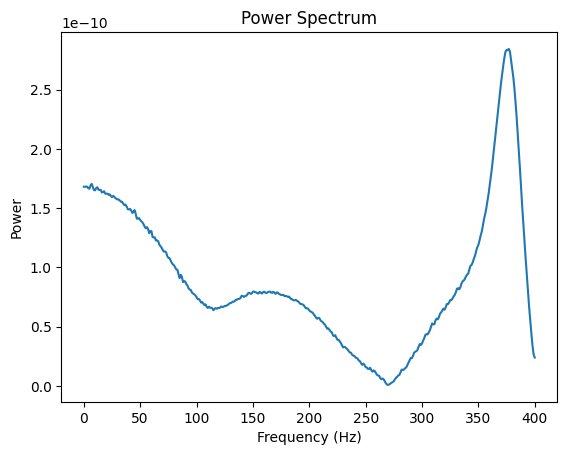

In [53]:
# get the rfft of the first 20Hz block
power_spectrum = np.abs(np.fft.rfft(song[:BLOCKSIZE], n=BLOCKSIZE))
# plot it with labeled axes
plt.plot(power_spectrum)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('Power Spectrum')
plt.show()

8.99627192115828e-11